In [200]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anm
import matplotlib.gridspec as gridspec

Class Cat


In [219]:
class Cat:
    """A class used to represent a Cat, patterns of its skin which are calculated by the Gierer-Meinhardt model.
    """
    
    
    def __init__(self, resolution:list, areas_dict:dict, parameters:dict):
        """ The init function which sets values of variables:
        
        Args:
            resolution (list): the resolution of full image,
            areas_dict (dict): dictionary with names and coordinates of body parts,
            parameters (dict): parameters of Gierer-Meinhardt model.


        Moreover, the init function automatically calculates the solution of Gierer-Meinhardt model
        and saves it as the variables matrices and total_matrices.
        """
        self.resolution = resolution
        self.areas_dict = areas_dict
        self.parameters = parameters

        self.matrices = {}
        self.total_matrices = []

        self.variance = 0
        
        self.GM_Neumann_2D()
        self.create_total_matrices()


    def create_total_matrices(self):
        """ Function creates the total matrix from matrices of solutions for each body parts
        and saves it as the variable total_matrices."""
        
        x_max = self.resolution[0]
        y_max = self.resolution[1]
        vec_t = np.arange(0, self.parameters["T_max"], self.parameters["h_t"])

        total_matrix = np.zeros((len(vec_t), y_max, x_max))
        for key in self.areas_dict.keys():
                x_0 = min(tup[0] for tup in self.areas_dict[key])
                x_1 = max(tup[0] for tup in self.areas_dict[key])
                y_0 = min(tup[1] for tup in self.areas_dict[key])
                y_1 = max(tup[1] for tup in self.areas_dict[key])
                total_matrix[:, y_0:y_1, x_0:x_1] = self.matrices[key][:, :, :]

        self.total_matrices = total_matrix
        

    def show_i_th_step(self, i: int):
        """ Function creates the plot of i-th step of the solution of Gierer-Meinhardt model.

        Args:
            i (int): the index of solution
        """
        x_max = self.resolution[0]
        y_max = self.resolution[1]

        total_matrix = np.zeros((y_max, x_max))
        for key in self.areas_dict.keys():
                x_0 = min(tup[0] for tup in self.areas_dict[key])
                x_1 = max(tup[0] for tup in self.areas_dict[key])
                y_0 = min(tup[1] for tup in self.areas_dict[key])
                y_1 = max(tup[1] for tup in self.areas_dict[key])
                total_matrix[(y_max-y_1):(y_max-y_0), (x_0):(x_1)] = self.matrices[key][i, ::-1, :]

        plt.imshow(total_matrix, cmap = "YlOrBr")

    def get_result_matrix(self):
        """Function returns the last step of the solution of Gierer-Meinhardt model
        in the plot coordinates (point (0,0) in the top left corner).

        Returns:
            list: Matrix of last step of the solution of Gierer-Meinhardt model.
        """
        x_max = self.resolution[0]
        y_max = self.resolution[1]

        total_matrix = np.zeros((y_max, x_max))
        for key in self.areas_dict.keys():
                x_0 = min(tup[0] for tup in self.areas_dict[key])
                x_1 = max(tup[0] for tup in self.areas_dict[key])
                y_0 = min(tup[1] for tup in self.areas_dict[key])
                y_1 = max(tup[1] for tup in self.areas_dict[key])
                total_matrix[(y_max-y_1):(y_max-y_0), (x_0):(x_1)] = self.matrices[key][-1, ::-1, :]

        return total_matrix
    
    def get_all_result_matrices(self):
        """Function returns all steps of the solution of Gierer-Meinhardt model.

        Returns:
            list: Matrix of solutions.
        """
        return self.total_matrices


    def get_variance(self):
         """Function calculates the weighted arithmetic mean of variances with wieghts 
         equal area of the appropriate body part (result matrix)

         Returns:
             float: weighted mean variance
         """
         sum_variance = 0
         sum_areas = 0

         for key in self.areas_dict.keys():
            x_0 = min(tup[0] for tup in self.areas_dict[key])
            x_1 = max(tup[0] for tup in self.areas_dict[key])
            y_0 = min(tup[1] for tup in self.areas_dict[key])
            y_1 = max(tup[1] for tup in self.areas_dict[key])
            area = (x_1 - x_0)*(y_1 - y_0)
            
            solution = self.matrices[key][-1, :, :]
            vector = np.reshape(solution, -1)
            variance = np.var(vector)

            sum_areas = sum_areas + area
            sum_variance = sum_variance + variance*area

            self.variance = sum_variance/sum_areas

         return  self.variance 


    def GM_Neumann_2D(self):
            """Function calculates the solution of Gierer-Meinhardt model using 
            finite difference numerical scheme with homogeneous Neumann conditions
            for each of the rectangle body parts separately.
            """
            h_x = self.parameters["h_x"]
            h_y = self.parameters["h_y"]
            h_t = self.parameters["h_t"]
            rho = self.parameters["rho"]
            mu_a = self.parameters["mu_a"]
            mu_h = self.parameters["mu_h"]
            D_a = self.parameters["D_a"]
            D_h = self.parameters[ "D_h"]
            rho_a = self.parameters["rho_a"]
            rho_h = self.parameters["rho_h"]
            T_max = self.parameters["T_max"]
            c = self.parameters["c"]
            a_0_func = lambda x, y: np.abs(np.random.random(x.shape))
            h_0_func = lambda x, y: np.abs(np.random.random(x.shape))
            g = lambda t: 0
            
            for key in self.areas_dict.keys():
                x_0 = min(tup[0] for tup in self.areas_dict[key])
                x_1 = max(tup[0] for tup in self.areas_dict[key])
                y_0 = min(tup[1] for tup in self.areas_dict[key])
                y_1 = max(tup[1] for tup in self.areas_dict[key])


                x = np.arange(x_0, x_1, h_x)
                y = np.arange(y_0, y_1, h_y)

                vec_t = np.arange(0, T_max, h_t)
                vec_x = np.meshgrid(x, y)[0]
                vec_y = np.meshgrid(x, y)[1]

                result_matrix_a_0 = a_0_func(vec_x, vec_y)
                result_matrix_a = np.zeros((len(vec_t), vec_y.shape[0], vec_x.shape[1]))
                result_matrix_a[0, 1:-1, 1:-1] = result_matrix_a_0[1:-1, 1:-1]
                result_matrix_a[0, 0, :] = result_matrix_a[0, 1, :] + h_x*g(0)
                result_matrix_a[0, -1, :] = result_matrix_a[0, -2, :] + h_x*g(0)
                result_matrix_a[0, :, 0] =  result_matrix_a[0, :, 1] + h_y*g(0)
                result_matrix_a[0, :, -1] = result_matrix_a[0, :, -2] + h_y*g(0)

                result_matrix_h_0 = h_0_func(vec_x, vec_y)
                result_matrix_h = np.zeros((len(vec_t), vec_y.shape[0], vec_x.shape[1]))
                result_matrix_h[0, 1:-1, 1:-1] = result_matrix_h_0[1:-1, 1:-1]
                result_matrix_h[0, 0, :] = result_matrix_h[0, 1, :] + h_x*g(0)
                result_matrix_h[0, -1, :] = result_matrix_h[0, -2, :] + h_x*g(0)
                result_matrix_h[0, :, 0] =  result_matrix_h[0, :, 1] + h_y*g(0)
                result_matrix_h[0, :, -1] = result_matrix_h[0, :, -2] + h_y*g(0)


                for i in range(len(vec_t) - 1):
                    t = vec_t[i]
                    result_matrix_a[i+1, 0, :] = result_matrix_a[i+1, 1, :] + h_x*g(t)
                    result_matrix_a[i+1, -1, :] = result_matrix_a[i+1, -2, :] + h_x*g(t)
                    result_matrix_a[i+1, :, 0] =  result_matrix_a[i+1, :, 1] + h_y*g(t)
                    result_matrix_a[i+1, :, -1] = result_matrix_a[i+1, :, -2] + h_y*g(t)

                    result_matrix_a[i+1, 1:-1, 1:-1] = result_matrix_a[i, 1:-1, 1:-1] + h_t*(D_a*((result_matrix_a[i, 2:, 1:-1] 
                                    + result_matrix_a[i, :-2, 1:-1] - 2*result_matrix_a[i, 1:-1, 1:-1])/h_x +
                                    + (result_matrix_a[i, 1:-1, 2:] + result_matrix_a[i, 1:-1, :-2] - 
                                    2*result_matrix_a[i, 1:-1, 1:-1])/h_y)
                                    + rho*(result_matrix_a[i, 1:-1, 1:-1]**2)/(result_matrix_h[i, 1:-1, 1:-1] *(1 + c*result_matrix_a[i, 1:-1, 1:-1]**2)) -  
                                    mu_a*result_matrix_a[i, 1:-1, 1:-1] +  rho_a)

                    result_matrix_h[i+1, 0, :] = result_matrix_h[i+1, 1, :] + h_x*g(t)
                    result_matrix_h[i+1, -1, :] = result_matrix_h[i+1, -2, :] + h_x*g(t)
                    result_matrix_h[i+1, :, 0] =  result_matrix_h[i+1, :, 1] + h_y*g(t)
                    result_matrix_h[i+1, :, -1] = result_matrix_h[i+1, :, -2] + h_y*g(t)

                    result_matrix_h[i+1, 1:-1, 1:-1] = result_matrix_h[i, 1:-1, 1:-1] + h_t*(D_h*((result_matrix_h[i, 2:, 1:-1] 
                                    + result_matrix_h[i, :-2, 1:-1] - 2*result_matrix_h[i, 1:-1, 1:-1])/h_x +
                                    + (result_matrix_h[i, 1:-1, 2:] + result_matrix_h[i, 1:-1, :-2] - 
                                    2*result_matrix_h[i, 1:-1, 1:-1])/h_y)
                                    + rho*(result_matrix_a[i, 1:-1, 1:-1]**2) - mu_h*result_matrix_h[i, 1:-1, 1:-1] + rho_h)

                self.matrices[key] = result_matrix_a[:, :, :]


    
    def animation(self):
        """Function creates the animation of the solutions of Gierer-Meinhardt model
        in time.

        Returns:
            FuncAnimation: animation.
        """
        x_max = self.resolution[0]
        y_max = self.resolution[1]
        x = np.arange(0, x_max, self.parameters["h_x"])
        y = np.arange(0, y_max, self.parameters["h_y"])
        
        total_matrices = self.total_matrices

        solution_a_cp = total_matrices[0::100, :, :]
        solution_a_cp = solution_a_cp.transpose()
        

        fig = plt.figure(figsize=(12, 5), facecolor='white')
        fig.suptitle("Gierer-Meinhardt model")

        gs = gridspec.GridSpec(1, 1)

        ax1 = plt.subplot(gs[0, 0])

        ax1.set_xlim((np.min(x), np.max(x)))
        ax1.set_ylim((np.min(y), np.max(y)))
        ax1.set_xlabel("$x$")
        ax1.set_ylabel("$y$")
        ax1.set_title("$a(x,y,t)$: intensity of the pigment")


        pcolormesh_d = ax1.pcolormesh(x, y, solution_a_cp[:,:,0].T, shading='gouraud', cmap = "YlOrBr")

        cb1 = fig.colorbar(pcolormesh_d, ax=ax1)

        def animation(j):
            pcolormesh_d.set_array((solution_a_cp[:, :, j].T).ravel())
            return pcolormesh_d

        anim = anm.FuncAnimation(fig,
                                func = animation,
                                frames = solution_a_cp.shape[2],
                                interval = 100,
                                blit = False
                                )
        plt.close()
        plt.rc('animation', html='jshtml')
        return anim
            

**Example**



In [220]:
areas_dict = {
  "leg_1": [(40,0), (40, 30), (50, 30), (50, 0)],
  "leg_2": [(60,0), (60, 30), (70, 30), (70, 0)],
  "leg_3": [(110, 0), (110, 30), (120, 30), (120, 0)],
  "leg_4": [(130, 0), (130, 30), (140, 30), (140, 0)],
  "body": [(40, 30), (40, 70), (140, 70), (140, 30)],
  "tail": [(40, 70),(40, 100), (50, 100), (50, 70)],
  "head": [(140, 50), (140, 80), (170, 80), (170, 50)]
}



parameters = {
  "h_x": 1,
  "h_y": 1,
  "h_t": 0.01,
  "rho": 1,
  "mu_a": 1.0,
  "mu_h": 1,
  "D_a": 0.02,
  "D_h": 2.0,
  "rho_a": 0.02,
  "rho_h": 0,
  "T_max": 100,
  "c": 0.2
}

In [221]:
cat1 = Cat([200, 100], areas_dict, parameters)

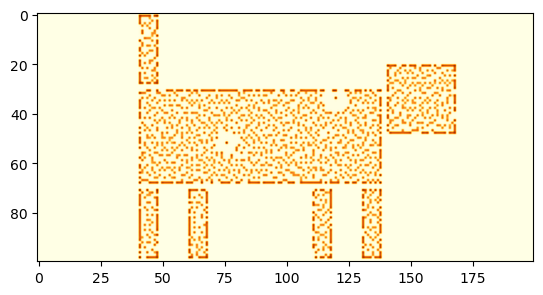

In [222]:
cat1.show_i_th_step(-1)

In [223]:
cat1.get_variance()

0.6205442391100293

In [ ]:
cat1.animation()

**Simulations**

Patterns depending on the parameter $c$:


$D_h = 2.0$

In [95]:
parameters = {
  "h_x": 1,
  "h_y": 1,
  "h_t": 0.01,
  "rho": 1,
  "mu_a": 1.0,
  "mu_h": 1,
  "D_a": 0.02,
  "D_h": 2.0,
  "rho_a": 0.02,
  "rho_h": 0,
  "T_max": 100,
  "c": 0.1
}
cat_c_01 = Cat([200, 100], areas_dict, parameters)

parameters["c"] = 0.5
cat_c_05 = Cat([200, 100], areas_dict, parameters)

parameters["c"] = 0.75
cat_c_075 = Cat([200, 100], areas_dict, parameters)

parameters["c"] = 1.2
cat_c_12 = Cat([200, 100], areas_dict, parameters)

Text(0.5, 1.0, '$c = 1.2$')

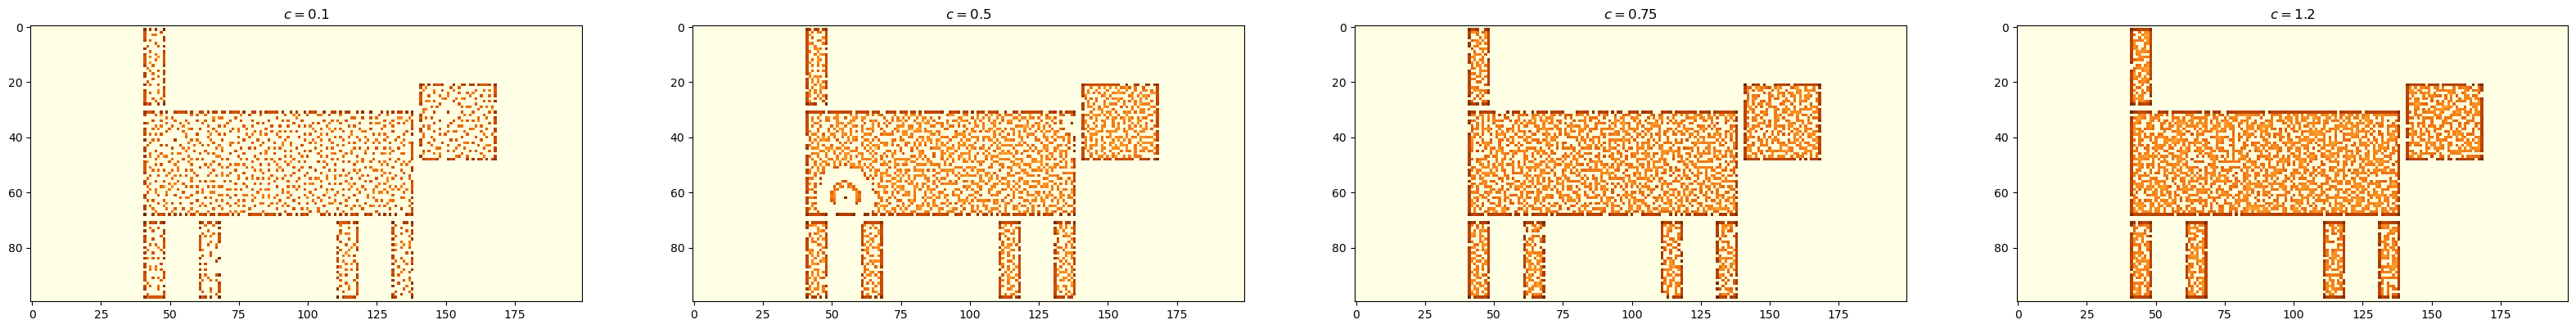

In [108]:
fig, axs = plt.subplots(1,4, figsize = (40, 40))
axs[0].imshow(cat_c_01.get_result_matrix(),  cmap = "YlOrBr")
axs[0].set_title("$c = 0.1$")

axs[1].imshow(cat_c_05.get_result_matrix(),  cmap = "YlOrBr")
axs[1].set_title("$c = 0.5$")

axs[2].imshow(cat_c_075.get_result_matrix(),  cmap = "YlOrBr")
axs[2].set_title("$c = 0.75$")

axs[3].imshow(cat_c_12.get_result_matrix(),  cmap = "YlOrBr")
axs[3].set_title("$c = 1.2$")


$D_h = 1.0$

In [109]:
parameters["D_h"] = 1.0
parameters["D_a"] = 1.0/100
parameters["c"] = 0.1
cat_c_01 = Cat([200, 100], areas_dict, parameters)

parameters["c"] = 0.5
cat_c_05 = Cat([200, 100], areas_dict, parameters)

parameters["c"] = 0.75
cat_c_075 = Cat([200, 100], areas_dict, parameters)

parameters["c"] = 1.2
cat_c_12 = Cat([200, 100], areas_dict, parameters)

Text(0.5, 1.0, '$c = 1.2$')

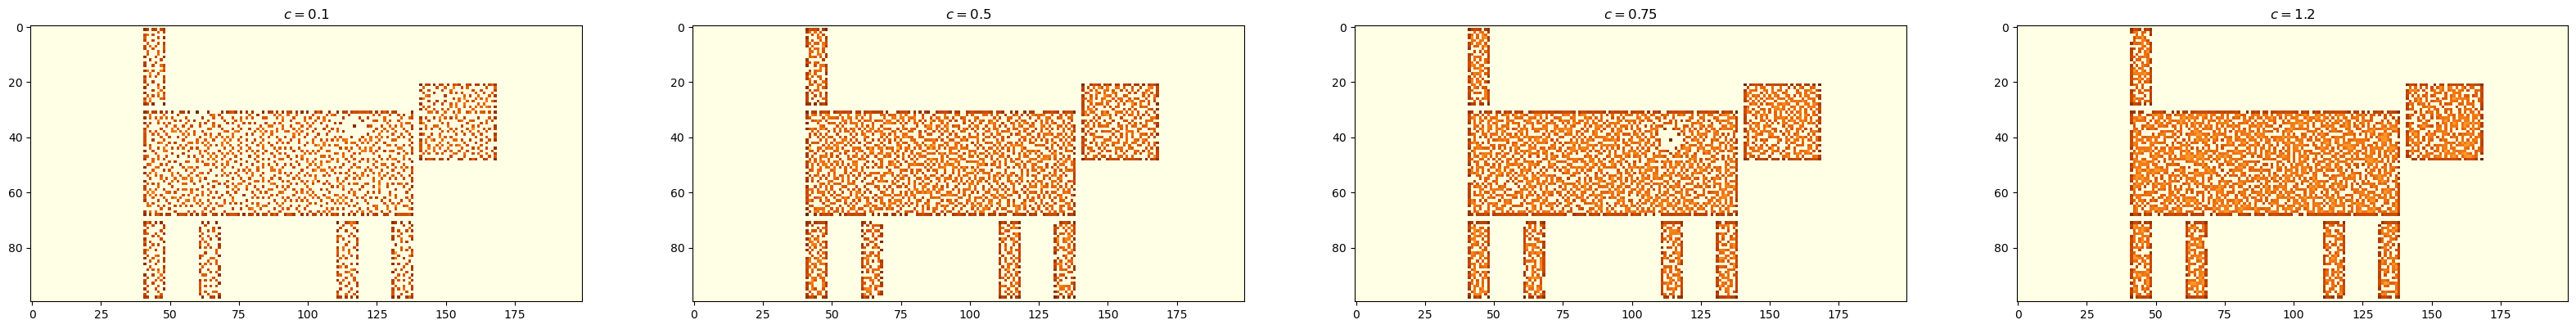

In [110]:
fig, axs = plt.subplots(1,4, figsize = (40, 40))
axs[0].imshow(cat_c_01.get_result_matrix(),  cmap = "YlOrBr")
axs[0].set_title("$c = 0.1$")

axs[1].imshow(cat_c_05.get_result_matrix(),  cmap = "YlOrBr")
axs[1].set_title("$c = 0.5$")

axs[2].imshow(cat_c_075.get_result_matrix(),  cmap = "YlOrBr")
axs[2].set_title("$c = 0.75$")

axs[3].imshow(cat_c_12.get_result_matrix(),  cmap = "YlOrBr")
axs[3].set_title("$c = 1.2$")


$D_h = 0.5$

In [111]:
parameters["D_h"] = 0.5
parameters["D_a"] = 0.5/100
parameters["c"] = 0.1
cat_c_01 = Cat([200, 100], areas_dict, parameters)

parameters["c"] = 0.5
cat_c_05 = Cat([200, 100], areas_dict, parameters)

parameters["c"] = 0.75
cat_c_075 = Cat([200, 100], areas_dict, parameters)

parameters["c"] = 1.2
cat_c_12 = Cat([200, 100], areas_dict, parameters)

Text(0.5, 1.0, '$c = 1.2$')

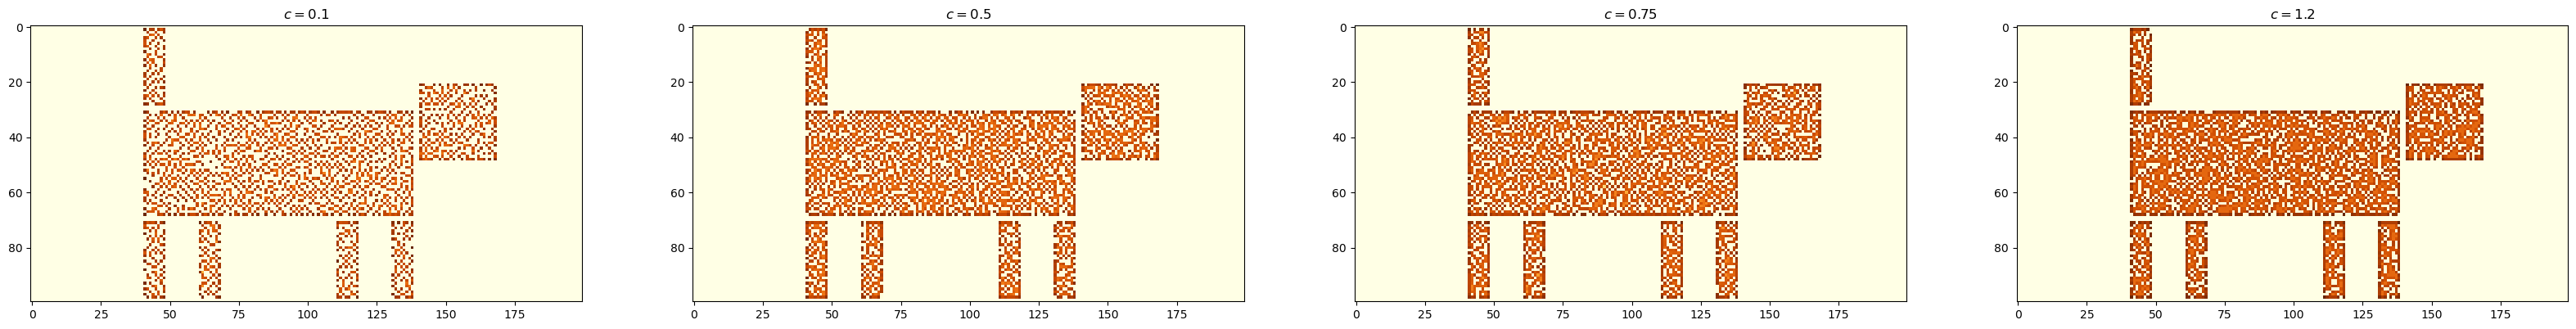

In [112]:
fig, axs = plt.subplots(1,4, figsize = (40, 40))
axs[0].imshow(cat_c_01.get_result_matrix(),  cmap = "YlOrBr")
axs[0].set_title("$c = 0.1$")

axs[1].imshow(cat_c_05.get_result_matrix(),  cmap = "YlOrBr")
axs[1].set_title("$c = 0.5$")

axs[2].imshow(cat_c_075.get_result_matrix(),  cmap = "YlOrBr")
axs[2].set_title("$c = 0.75$")

axs[3].imshow(cat_c_12.get_result_matrix(),  cmap = "YlOrBr")
axs[3].set_title("$c = 1.2$")

Patterns depending on the parameter $\mu_a$:


$\mu_h = 0.3$

In [190]:
parameters = {
  "h_x": 1,
  "h_y": 1,
  "h_t": 0.01,
  "rho": 1,
  "mu_a": 0.1,
  "mu_h": 0.3,
  "D_a": 0.02,
  "D_h": 2.0,
  "rho_a": 0.02,
  "rho_h": 0,
  "T_max": 100,
  "c": 0.1
}
cat_c_01 = Cat([200, 100], areas_dict, parameters)

parameters["mu_a"] = 0.5
cat_c_05 = Cat([200, 100], areas_dict, parameters)

parameters["mu_a"] = 0.75
cat_c_075 = Cat([200, 100], areas_dict, parameters)

parameters["mu_a"] = 1.2
cat_c_12 = Cat([200, 100], areas_dict, parameters)

Text(0.5, 1.0, '$\\mu_a = 1.2$')

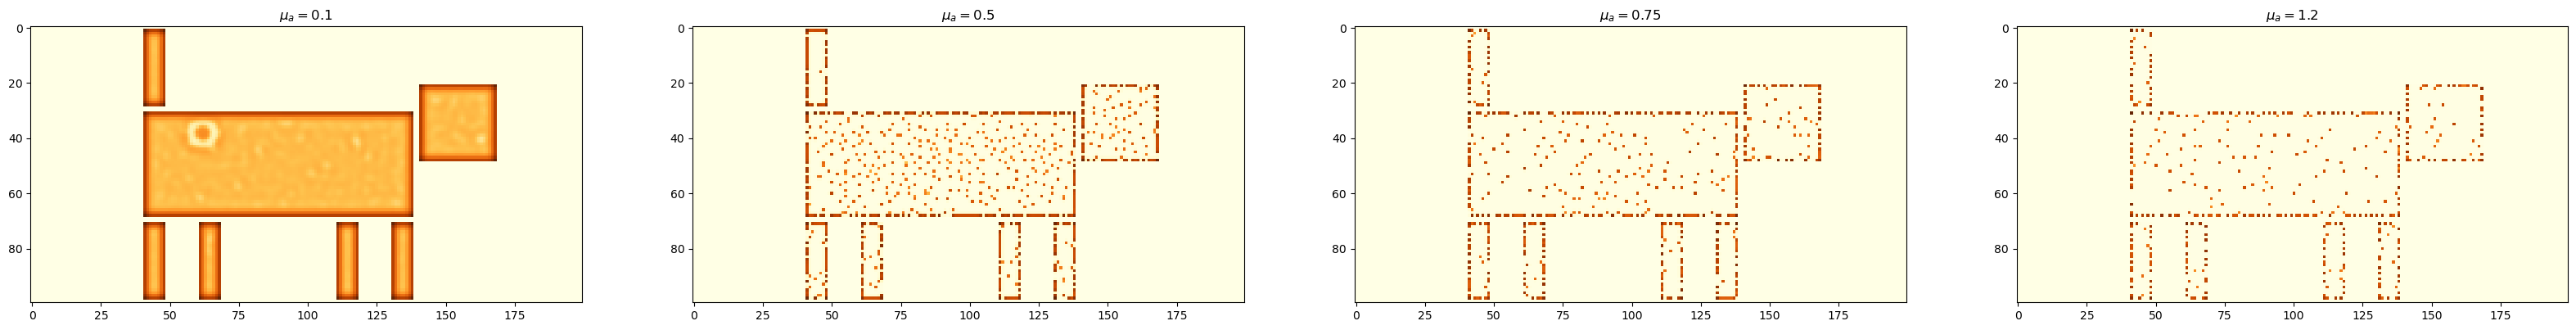

In [191]:
fig, axs = plt.subplots(1,4, figsize = (40, 40))
axs[0].imshow(cat_c_01.get_result_matrix(),  cmap = "YlOrBr")
axs[0].set_title("$\mu_a = 0.1$")

axs[1].imshow(cat_c_05.get_result_matrix(),  cmap = "YlOrBr")
axs[1].set_title("$\mu_a = 0.5$")

axs[2].imshow(cat_c_075.get_result_matrix(),  cmap = "YlOrBr")
axs[2].set_title("$\mu_a = 0.75$")

axs[3].imshow(cat_c_12.get_result_matrix(),  cmap = "YlOrBr")
axs[3].set_title("$\mu_a = 1.2$")

$\mu_h = 0.5$

In [192]:
parameters["mu_h"] = 0.5
parameters["mu_a"] = 0.1
cat_c_01 = Cat([200, 100], areas_dict, parameters)

parameters["mu_a"] = 0.5
cat_c_05 = Cat([200, 100], areas_dict, parameters)

parameters["mu_a"] = 0.75
cat_c_075 = Cat([200, 100], areas_dict, parameters)

parameters["mu_a"] = 1.2
cat_c_12 = Cat([200, 100], areas_dict, parameters)

Text(0.5, 1.0, '$\\mu_a = 1.2$')

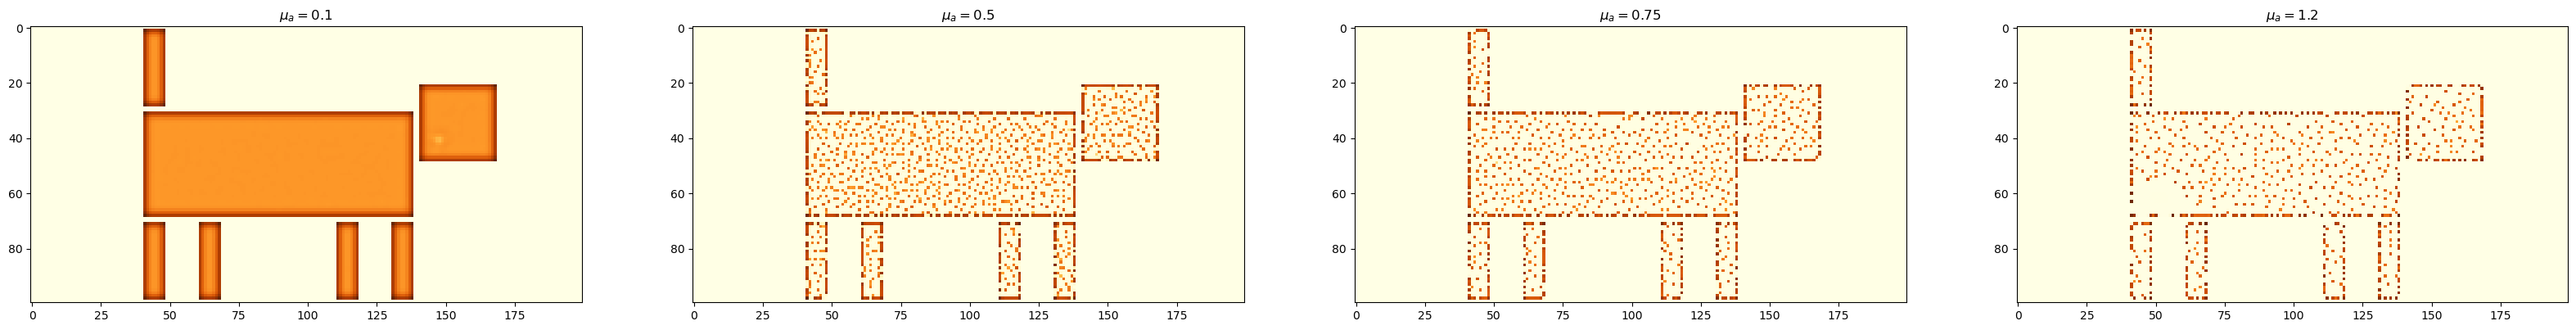

In [193]:
fig, axs = plt.subplots(1,4, figsize = (40, 40))
axs[0].imshow(cat_c_01.get_result_matrix(),  cmap = "YlOrBr")
axs[0].set_title("$\mu_a = 0.1$")

axs[1].imshow(cat_c_05.get_result_matrix(),  cmap = "YlOrBr")
axs[1].set_title("$\mu_a = 0.5$")

axs[2].imshow(cat_c_075.get_result_matrix(),  cmap = "YlOrBr")
axs[2].set_title("$\mu_a = 0.75$")

axs[3].imshow(cat_c_12.get_result_matrix(),  cmap = "YlOrBr")
axs[3].set_title("$\mu_a = 1.2$")

$\mu_h = 1.0$

In [194]:
parameters["mu_h"] = 1.0
parameters["mu_a"] = 0.1
cat_c_01 = Cat([200, 100], areas_dict, parameters)

parameters["mu_a"] = 0.5
cat_c_05 = Cat([200, 100], areas_dict, parameters)

parameters["mu_a"] = 0.75
cat_c_075 = Cat([200, 100], areas_dict, parameters)

parameters["mu_a"] = 1.2
cat_c_12 = Cat([200, 100], areas_dict, parameters)

Text(0.5, 1.0, '$\\mu_a = 1.2$')

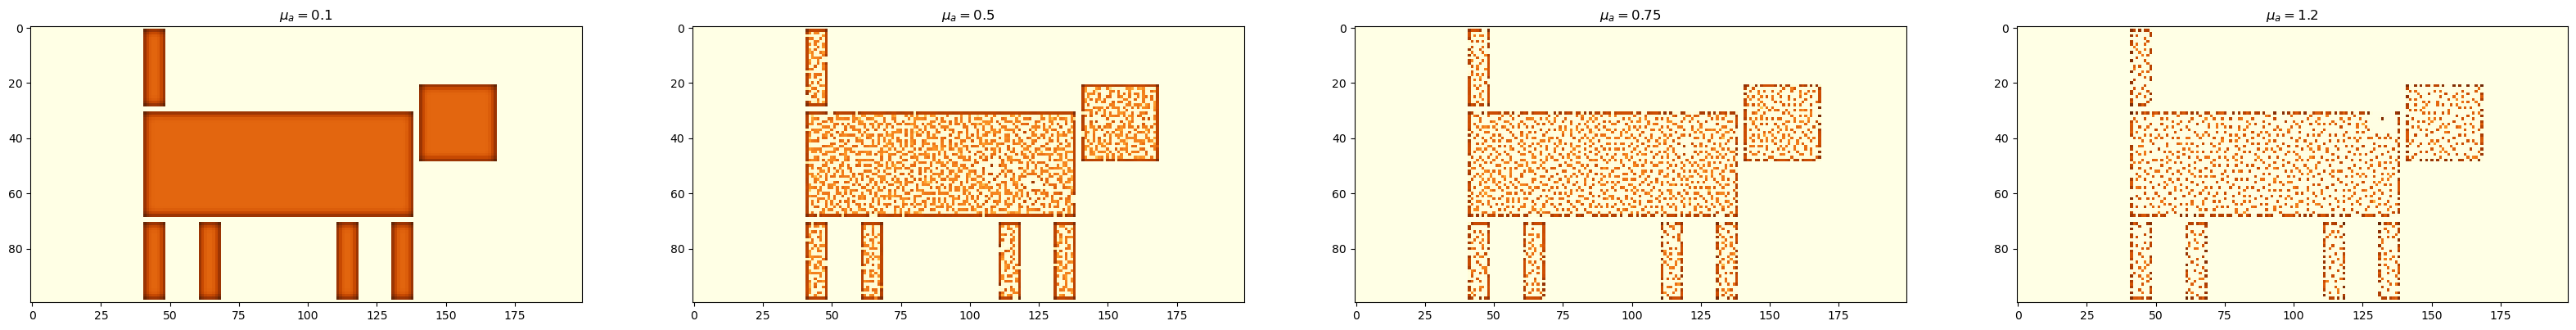

In [195]:
fig, axs = plt.subplots(1,4, figsize = (40, 40))
axs[0].imshow(cat_c_01.get_result_matrix(),  cmap = "YlOrBr")
axs[0].set_title("$\mu_a = 0.1$")

axs[1].imshow(cat_c_05.get_result_matrix(),  cmap = "YlOrBr")
axs[1].set_title("$\mu_a = 0.5$")

axs[2].imshow(cat_c_075.get_result_matrix(),  cmap = "YlOrBr")
axs[2].set_title("$\mu_a = 0.75$")

axs[3].imshow(cat_c_12.get_result_matrix(),  cmap = "YlOrBr")
axs[3].set_title("$\mu_a = 1.2$")

**Variance**

Parameter $c$

In [174]:
parameters_0 = {
  "h_x": 1,
  "h_y": 1,
  "h_t": 0.01,
  "rho": 1,
  "mu_a": 1.0,
  "mu_h": 1,
  "D_a": 0.01,
  "D_h": 1.0,
  "rho_a": 0.02,
  "rho_h": 0,
  "T_max": 100,
  "c": 0.1
}

parameters = parameters_0
vec_c = np.arange(0.1, 2, 0.1)
vec_variance_c = []

for c in vec_c:
    parameters["c"] = c
    cat = Cat([200, 100], areas_dict, parameters)
    vec_variance_c.append(cat.get_variance())

Parameter $D_h$

In [126]:
parameters = parameters_0
vec_D_h = np.arange(0.1, 2, 0.1)
vec_variance_D_h = []

for D_h in vec_D_h:
    parameters["D_h"] = D_h
    parameters["D_a"] = D_h/100
    cat = Cat([200, 100], areas_dict, parameters)
    vec_variance_D_h.append(cat.get_variance())

Parameter $\mu_a$

In [128]:
parameters = parameters_0
vec_mu_a = np.arange(0.1, 2, 0.1)
vec_variance_mu_a = []

for mu_a in vec_mu_a:
    parameters["mu_a"] = mu_a
    cat = Cat([200, 100], areas_dict, parameters)
    vec_variance_mu_a.append(cat.get_variance())

Parameter $\mu_h$

In [132]:
parameters = parameters_0
vec_mu_h = np.arange(0.1, 2, 0.1)
vec_variance_mu_h = []

for mu_h in vec_mu_h:
    parameters["mu_h"] = mu_h
    cat = Cat([200, 100], areas_dict, parameters)
    vec_variance_mu_h.append(cat.get_variance())

Parameter $\rho_a$

In [183]:
parameters = parameters_0
vec_rho_a = np.arange(0.1, 2, 0.1)
vec_variance_rho_a = []

for rho_a in vec_rho_a:
    parameters["rho_a"] = rho_a
    cat = Cat([200, 100], areas_dict, parameters)
    vec_variance_rho_a.append(cat.get_variance())

Parameter $\rho_h$

In [ ]:
parameters = parameters_0
vec_rho_h = np.arange(0.1, 2, 0.1)
vec_variance_rho_h = []

for rho_h in vec_rho_h:
    parameters["rho_h"] = rho_h
    cat = Cat([200, 100], areas_dict, parameters)
    vec_variance_rho_h.append(cat.get_variance())

Parameter $\rho$

In [150]:
parameters = parameters_0
vec_rho = np.arange(0.1, 2, 0.1)
vec_variance_rho = []

for rho in vec_rho:
    parameters["rho"] = rho
    cat = Cat([200, 100], areas_dict, parameters)
    vec_variance_rho.append(cat.get_variance())

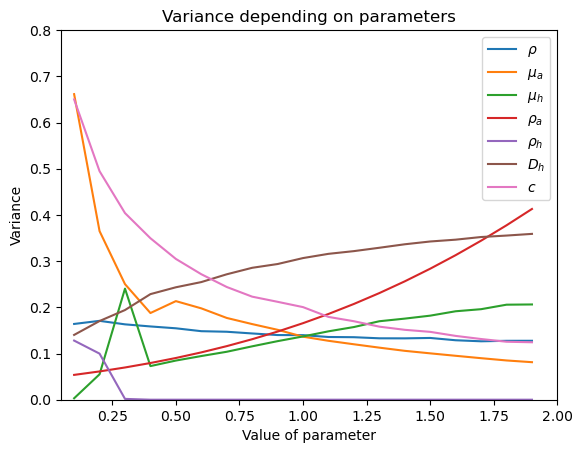

In [187]:
plt.plot(vec_rho, vec_variance_rho, label = "$\\rho$")
plt.plot(vec_mu_a, vec_variance_mu_a, label = "$\mu_a$")
plt.plot(vec_mu_h, vec_variance_mu_h, label = "$\mu_h$")
plt.plot(vec_rho_a, vec_variance_rho_a, label = "$\\rho_a$")
plt.plot(vec_rho_h, vec_variance_rho_h, label = "$\\rho_h$")
plt.plot(vec_D_h, vec_variance_D_h,  label = "$D_h$")
plt.plot(vec_c, vec_variance_c,  label = "$c$")
plt.title("Variance depending on parameters")
plt.xlabel("Value of parameter")
plt.ylabel("Variance")
plt.ylim(0, 0.8)
plt.xlim(0.05, 2)
plt.legend()

**Error of doubling the time step**

In [202]:
areas_dict = {
  "square": [(0, 0), (0, 100), (100, 0), (100,100)]
}



parameters = {
  "h_x": 1,
  "h_y": 1,
  "h_t": 0.01,
  "rho": 1,
  "mu_a": 1.0,
  "mu_h": 1,
  "D_a": 0.02,
  "D_h": 2.0,
  "rho_a": 0.02,
  "rho_h": 0,
  "T_max": 100,
  "c": 0.2
}

In [208]:
hsteps = np.arange(0.25, 5, 0.01)
errors = []

for h in hsteps:
  parameters["h_t"] = h
  cat = Cat([100, 100], areas_dict, parameters)
  solution =  cat.get_all_result_matrices()

  parameters["h_t"] = h/2
  cat = Cat([100, 100], areas_dict, parameters)
  solution_doubled = cat.get_all_result_matrices()


  try:
    errors.append(np.mean(np.abs(solution - solution_doubled[::2, :])))
  except:
    errors.append(np.mean(np.abs(solution[:-1, :] - solution_doubled[::2, :])))

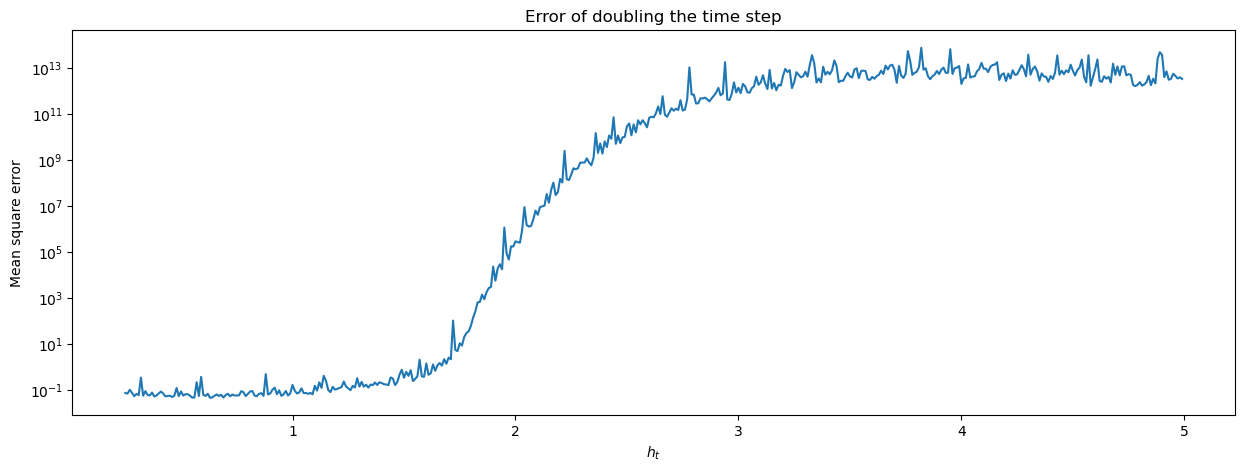

In [209]:
plt.figure(figsize=(15, 5))
plt.title("Error of doubling the time step")
plt.xlabel("$h_t$")
plt.ylabel("Mean square error")
plt.plot(hsteps, errors)
plt.yscale('log')

Mathematical model: **Gierer-Meinhardt model**

$$\frac{\partial a}{ \partial t} = \frac{\rho  \cdot a^2}{h(1 + c \cdot a^2)} - \mu_a a + D_a \Delta a + \rho_a$$

$$\frac{\partial h}{ \partial t} = \rho a^2 - \mu_h h + D_h \Delta h + \rho_h,$$

where $ \Delta f(x,y) = \frac{\partial^2 f}{ \partial x^2} + \frac{\partial^2 f}{ \partial y^2}$.


The above model is a reaction-diffusion system of the activator-inhibitor type, so it describes the pattern formation.

Variables:

* $a$: a slowly diffusing *activator* - the substance responsible for the intensity of the pigment,

* $h$: a fast diffusing *inhibitor* - the antagonist which suppresses the value of $a$.


The first eqaution - change of activator concentration $\frac{\partial a}{ \partial t}$:

* $ \frac{\rho  \cdot a^2}{h(1 + c \cdot a^2)}$: the production rate (it depends in non-linear way of $a$ and is slowed down by the inhabitor $1/h$ and by its own value),

* $- \mu_a a$: the number of molecules that decay per time unit (proportial to the decay rate $\mu_a$ and $a$),

* $D_a \Delta a$: the exchange (diffusion) of molecules,

* $\rho_a$: small activator-independent production rate.

The meaning of the second equation for $\frac{\partial h}{ \partial t}$ is analogous.


We will assume that the initial pigment distribution is random and indepenedent in each part of the body (head, body, tail and legs).

In this case we assume that there is no flow at the edges: **homogeneous Neumann conditions**:

$$ \frac{\partial a}{∂ n} (x,y,t) = \nabla a (x,y,t) ⋅ n(x,y) = g(t) = 0,$$

$$ \frac{\partial h}{∂ n} (x,y,t) = \nabla h (x,y,t) ⋅ n(x,y) = g(t) = 0.$$


We will find the numerical scheme **for each part of the body separately** (for the rectangles: $[0,L] \times [0,M]$).


**Finite difference numerical scheme**

At the beginning we will approximate the value of Laplace operator:

$$Δ a = a_{xx}(x,t)\approx \frac{a(x+h_x,t) - 2 a(x,t) + a(x-h_x,t)}{h_x^2}.$$


So:

\begin{align}
  Δa(x, y, t) &≈ \frac{∂^2a(x,y,t)}{∂x^2} + \frac{∂^2a(x,y,t)}{∂y^2} ≈  \\
  &≈ \frac{a(x + h_x, y, t) - 2a(x, y, t) + a(x - h_x, y, t)}{h_x^2} + \frac{a(x, y + h_y, t) - 2a(x, y, t) + a(x, y - h_y, t)}{h_y^2}.
\end{align}

We get the analogical formula for $Δ h$.

* We have:

$$a_t = \frac{\rho  \cdot a^2}{h(1 + c \cdot a^2)} - \mu_a a + D_a \Delta a + \rho_a / \int_t^{t+h_t}$$

$$a(x, y, t+h_t) ≈ a(x,y,t) + h_t \cdot \left( \frac{\rho  \cdot a^2}{h(1 + c \cdot a^2)} - \mu_a a + D_a \Delta a + \rho_a \right).$$

In matrix notation:

$$a_{i,j,k+1} ≈ a_{i,j,k} + h_t \cdot \left( \frac{\rho \cdot a_{i,j,k}^2}{h_{i,j,k} \cdot (1 + c \cdot a_{i,j,k}^2)} - \mu_a a_{i,j,k} + D_a \Delta a_{i,j,k} + \rho_a \right).$$

* Similarly for the second equation:

$$h_t = \rho a^2 - \mu_h h + D_h \Delta h + \rho_h / \int_t^{t+h_t}$$

$$h(x, y, t+h_t) ≈ h(x,y,t) + h_t \cdot(\rho a^2 - \mu_h h + D_h \Delta h + \rho_h).$$

So:

$$h_{i,j,k+1} ≈ h_{i,j,k} + h_t \cdot(\rho a_{i,j,k}^2 - \mu_h h_{i,j,k} + D_h \Delta h_{i,j,k} + \rho_h).$$

The above formulas are correct for $(x_i, y_j) \notin \partial\Omega$. Moreover, using the homogeneous Neumann conditions ($g(t)=0$) we get at the edge:

$$
\mathrm{u}_{i, j, k+1} = \begin{cases}
    u_{L-1, j, k+1} + h_x g(t_{k+1})  & \text{if } x_i = L, 0 \leq y_j \leq M, \\
    u_{1, j, k+1} + h_x g(t_{k+1}) & \text{if } x_i = 0, 0 \leq y_j \leq M, \\
    u_{i, L-1, k+1} + h_x g(t_{k+1}) & \text{if } 0 \leq x_i \leq L, y_j = M, \\
    u_{i, 1, k+1} + h_x g(t_{k+1}) & \text{if } 0 \leq x_i \leq L, y_j = 0,
\end{cases}
$$

where $u = a$ or $u = h$.

**Measuring diversity**

We have to compare the resulting patterns in terms of diversity. 

We will use the following method:

1. We get the results matices for each body parts.

2. We rewrite matrices as vectors.

3. We count the variance of each vector.

4. We set the result variance as the weighted arithmetic mean of variances with wieghts equal area of the appropriate body part (result matrix).


Using weighted mean allows us to retain information about the animal's proportions. 

We don't count for example the covariances of matrices, because we compare just a value of function $a$ (pigment concentration) and we are interested to calculate the diversity of this value - we would use the corresponding method also in 1D or 3D cases.